In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, LeakyReLU, ReLU, LayerNormalization, GaussianNoise
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D
from keras import initializers
from math import ceil
import time
from tensorflow_addons.layers import SpectralNormalization

In [2]:
#Updated Versions
#Spectral Normalization Model
def build_cifar10_discriminator(image_shape=(32, 32, 3)):
    
    model = Sequential()
    
    #16 output filters, so number of channels jumps from 1 to 16
    #kernel_size = 5 means we use a 5x5 convolution window
    #strides defaults to (1,1) when unspecified, "same" padding means we'll preserve the image size
    model.add(Conv2D(16, kernel_size=5, strides=2, padding="same", input_shape=(32, 32, 3), 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))) #40
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(32, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    
    #Second layer
    model.add(SpectralNormalization(Conv2D(64, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(128, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))

    #Flatten for Final Output Layer
    model.add(Flatten())

    #Output layer
    model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Activation("sigmoid"))
    
    #Final Output
    print("\nDiscriminator")
    model.summary()
    return model




#Spectral Normalization Model
def build_cifar10_generator(z_dim=100):
    
    model = Sequential()
    
    #First Layer (4x4)
    model.add(Dense(4*4*128, input_dim=z_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Reshape((4,4,128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 8x8
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
          use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    
    # output layer
    model.add(Activation('tanh'))

    print("\nGenerator")
    model.summary()
    return model




#Build and Compile Networks
#Variables
#Loss Functions:  Don't seem to matter for performance, any choice will work
#Learning rates:  Trying higher learning rate for Discriminator;  
#Discriminator is easier to succeed, gives generator a better chance at competition, prevents mode collapse
lr_d=2e-4
lr_g=1e-4
z_dim=100
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
image_shape = X_train[0].shape

D = build_cifar10_discriminator(image_shape)
G = build_cifar10_generator(z_dim)

D.compile(Adam(learning_rate=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
D.trainable = False

z = Input(shape=(z_dim, ))
D_of_G = Model(inputs=z, outputs=D(G(z)))
D_of_G.compile(Adam(learning_rate=lr_g, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])


Discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 spectral_normalization (Spe  (None, 8, 8, 32)         12864     
 ctralNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 spectral_normalization_1 (S  (None, 4, 4, 64)         51328     
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4,

In [3]:
#Function for plotting images
def plot_images(images, filename):
    h, w, c = images.shape[1:]
    #images = (1/(2*2.25)) * images + 0.5
    images = 0.5 * images + 0.5
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    
#Function for Plotting Losses During Training
def plot_losses(losses_d, losses_g, filename):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    #plt.close()
    
#Functions for smoothing labels of 1 and 0
# Smoothing class=1 to [0.8, 1.0]
def smooth_positive_labels(y):
    return y - 0.2 + (np.random.random(y.shape) * 0.2)

# Smoothing class=0 to [0.0, 0.1]
def smooth_negative_labels(y):
    return y + (np.random.random(y.shape) * 0.1)

#Function for generating latent points to feed into generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
     x_input = np.random.randn(latent_dim * n_samples)
     # reshape into a batch of inputs for the network
     x_input = x_input.reshape((n_samples, latent_dim))
     return x_input
    

#Function for adding noise to images
#  Adding noise to images prevents discriminator overfitting, inhibits performance to allow
#   for better rivalry with the generator (which is generally slower to train)
#This function adds 'salt and pepper noise' (randomly set pixels to either -1 or 1) 
# def noisy(image):
#     row,col,ch = image.shape
#     s_vs_p = 0.5
#     amount = 0.004
#     out = np.copy(image)
#     # Salt mode
#     num_salt = np.ceil(amount * image.size * s_vs_p)
#     coords = tuple([np.random.randint(0, i - 1, int(num_salt))
#             for i in image.shape])
#     out[coords] = 1

#     # Pepper mode
#     num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
#     coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
#             for i in image.shape])
#     out[coords] = -1
#     return out

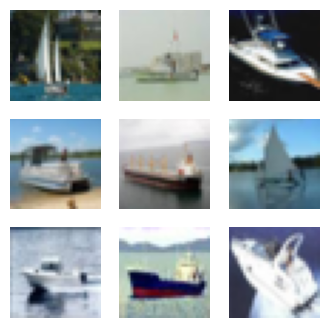

In [4]:
# #Test only grabbing images of one type

#Load the CIFAR10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#Concatenate X_train and X_test for more data
X_train = np.concatenate((X_train,X_test))
y_train = np.concatenate((y_train,y_test))
#Only use index 0, AKA Airplanes
index = np.where(y_train.reshape(-1) == 8)
X_train = X_train[index]
y_train = y_train[index]

#Testing to make sure it's just airplanes
fig,axs = plt.subplots(3,3,figsize=(4,4),sharey=True,sharex=True)
cnt=0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X_train[-9:][cnt,:,:])
        axs[i, j].axis('off')
        cnt+=1

image shape (32, 32, 3), min val -0.9372549057006836, max val 0.9764705896377563
Epoch 0
Time for epoch:  27.559187412261963
loss_d=0.38477, loss_g=1.23429
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

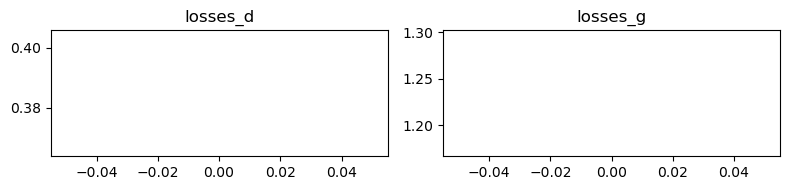

Epoch 1
Time for epoch:  23.897220611572266
Epoch 2
Time for epoch:  23.208733558654785
Epoch 3
Time for epoch:  24.87381625175476
Epoch 4
Time for epoch:  24.983091115951538
Epoch 5
Time for epoch:  24.56744623184204
loss_d=0.59776, loss_g=0.97184
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


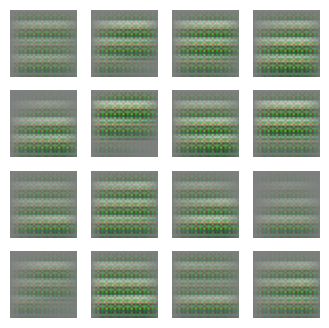

<Figure size 1600x1600 with 0 Axes>

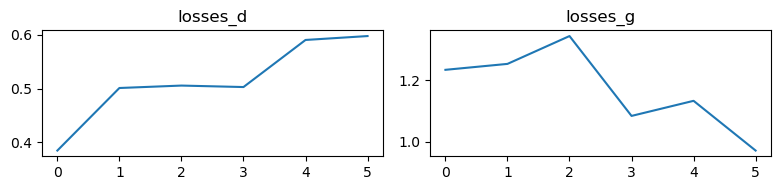

Epoch 6
Time for epoch:  24.605263710021973
Epoch 7
Time for epoch:  24.84876275062561
Epoch 8
Time for epoch:  24.873947143554688
Epoch 9
Time for epoch:  24.66309404373169
Epoch 10
Time for epoch:  24.5767502784729
loss_d=0.72372, loss_g=1.27415
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


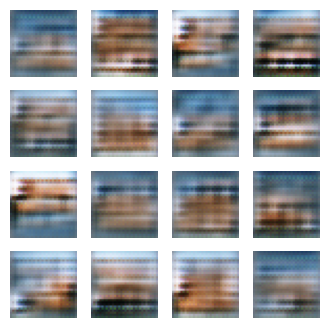

<Figure size 1600x1600 with 0 Axes>

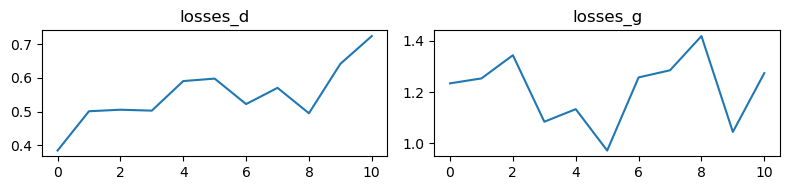

Epoch 11
Time for epoch:  25.09121584892273
Epoch 12
Time for epoch:  24.75994634628296
Epoch 13
Time for epoch:  25.250873565673828
Epoch 14
Time for epoch:  24.766863107681274
Epoch 15
Time for epoch:  25.03828477859497
loss_d=0.60356, loss_g=1.16857
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


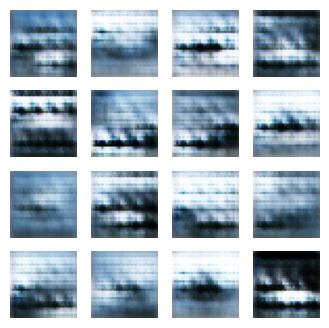

<Figure size 1600x1600 with 0 Axes>

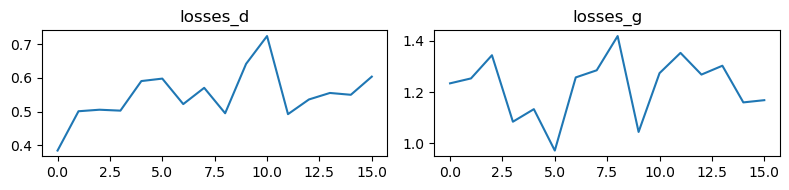

Epoch 16
Time for epoch:  24.54679298400879
Epoch 17
Time for epoch:  24.446526527404785
Epoch 18
Time for epoch:  24.496643543243408
Epoch 19
Time for epoch:  24.84703040122986
Epoch 20
Time for epoch:  24.678004264831543
loss_d=0.51860, loss_g=1.30623
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


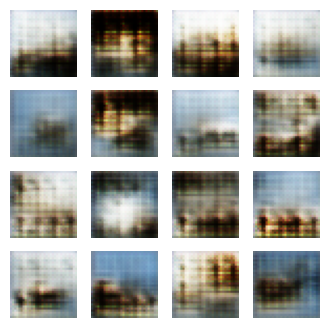

<Figure size 1600x1600 with 0 Axes>

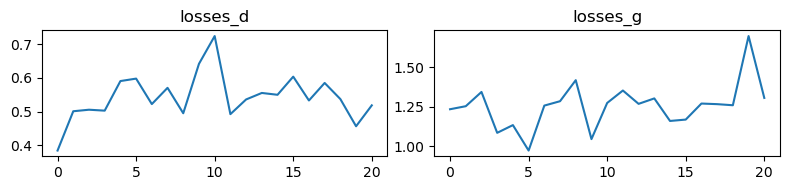

Epoch 21
Time for epoch:  24.6263370513916
Epoch 22
Time for epoch:  24.600629329681396
Epoch 23
Time for epoch:  24.95933222770691
Epoch 24
Time for epoch:  25.728957891464233
Epoch 25
Time for epoch:  24.712080717086792
loss_d=0.57088, loss_g=1.11446
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


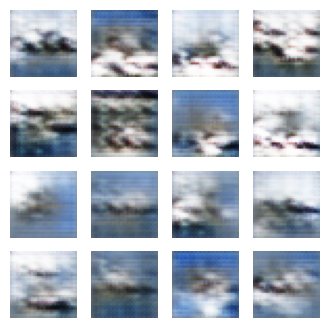

<Figure size 1600x1600 with 0 Axes>

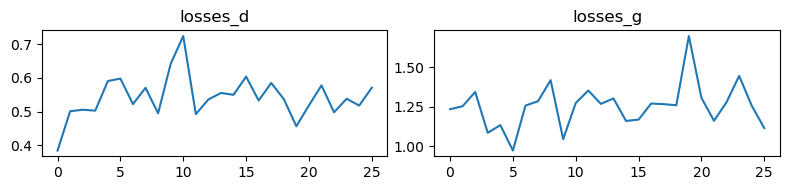

Epoch 26
Time for epoch:  25.226048469543457
Epoch 27
Time for epoch:  24.56581974029541
Epoch 28
Time for epoch:  24.685530424118042
Epoch 29
Time for epoch:  24.562854051589966
Epoch 30
Time for epoch:  24.914400100708008
loss_d=0.59108, loss_g=1.02637
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


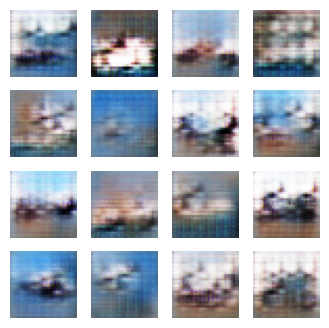

<Figure size 1600x1600 with 0 Axes>

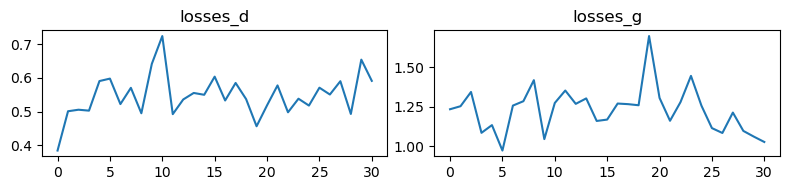

Epoch 31
Time for epoch:  24.59022879600525
Epoch 32
Time for epoch:  24.50684356689453
Epoch 33
Time for epoch:  24.598077535629272
Epoch 34
Time for epoch:  25.042675256729126
Epoch 35
Time for epoch:  24.70813488960266
loss_d=0.58269, loss_g=1.26175
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


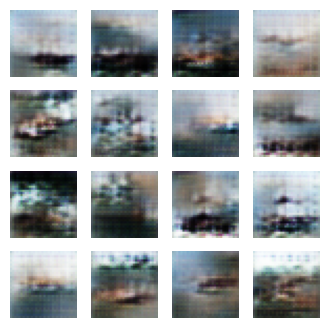

<Figure size 1600x1600 with 0 Axes>

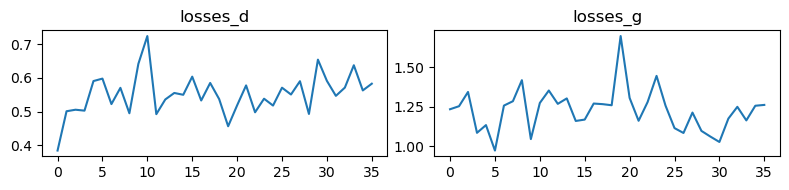

Epoch 36
Time for epoch:  25.369070053100586
Epoch 37
Time for epoch:  25.373866081237793
Epoch 38
Time for epoch:  25.391133308410645
Epoch 39
Time for epoch:  25.257311820983887
Epoch 40
Time for epoch:  25.150590419769287
loss_d=0.56150, loss_g=1.27659
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


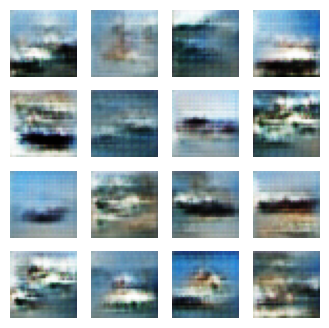

<Figure size 1600x1600 with 0 Axes>

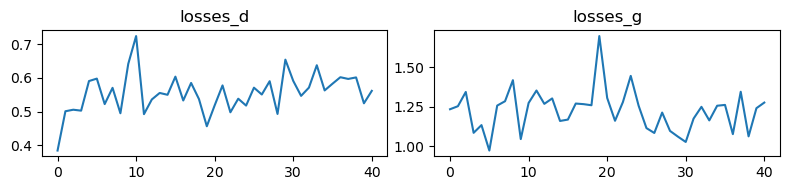

Epoch 41
Time for epoch:  24.641660928726196
Epoch 42
Time for epoch:  26.01428747177124
Epoch 43
Time for epoch:  24.709241151809692
Epoch 44
Time for epoch:  24.774518489837646
Epoch 45
Time for epoch:  25.296297788619995
loss_d=0.55284, loss_g=1.17315
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


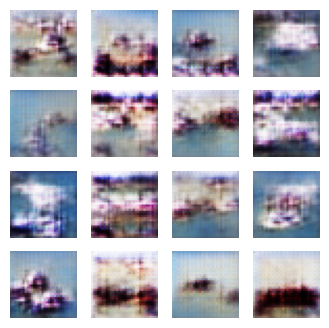

<Figure size 1600x1600 with 0 Axes>

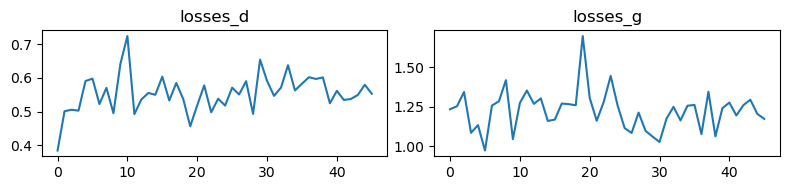

Epoch 46
Time for epoch:  25.249451875686646
Epoch 47
Time for epoch:  24.76888680458069
Epoch 48
Time for epoch:  24.99971628189087
Epoch 49
Time for epoch:  24.772438287734985
Epoch 50
Time for epoch:  25.173200845718384
loss_d=0.48590, loss_g=1.52508
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


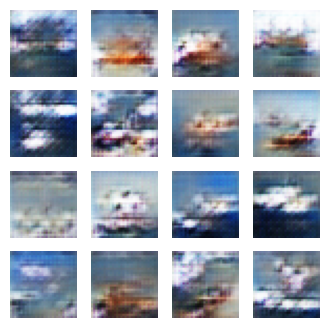

<Figure size 1600x1600 with 0 Axes>

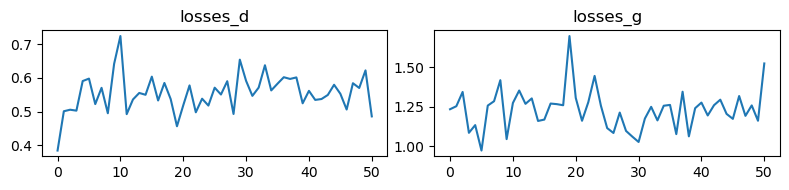

Epoch 51
Time for epoch:  24.698380708694458
Epoch 52
Time for epoch:  25.04651379585266
Epoch 53
Time for epoch:  24.804648876190186
Epoch 54
Time for epoch:  25.566457271575928
Epoch 55
Time for epoch:  25.25290298461914
loss_d=0.55247, loss_g=1.26231
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


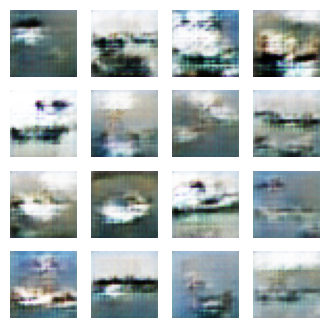

<Figure size 1600x1600 with 0 Axes>

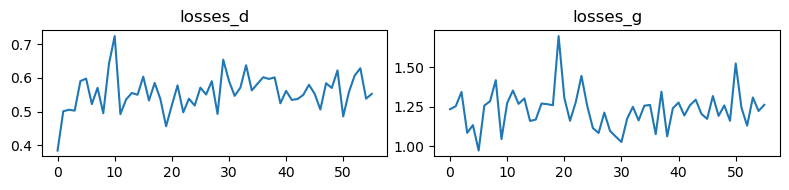

Epoch 56
Time for epoch:  24.766091108322144
Epoch 57
Time for epoch:  25.009335041046143
Epoch 58
Time for epoch:  24.63642692565918
Epoch 59
Time for epoch:  24.858429431915283
Epoch 60
Time for epoch:  24.510652542114258
loss_d=0.58350, loss_g=1.16040
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


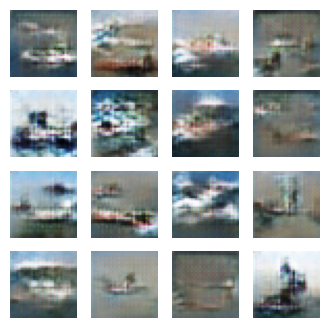

<Figure size 1600x1600 with 0 Axes>

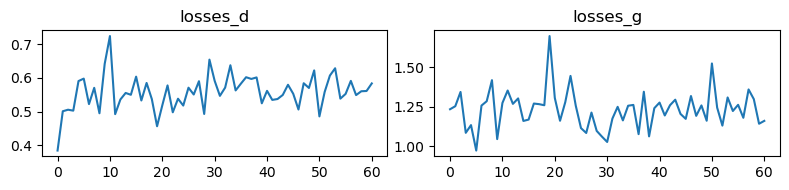

Epoch 61
Time for epoch:  24.96256375312805
Epoch 62
Time for epoch:  22.646384477615356
Epoch 63
Time for epoch:  22.865338563919067
Epoch 64
Time for epoch:  23.23618483543396
Epoch 65
Time for epoch:  22.71620464324951
loss_d=0.57640, loss_g=1.16854
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


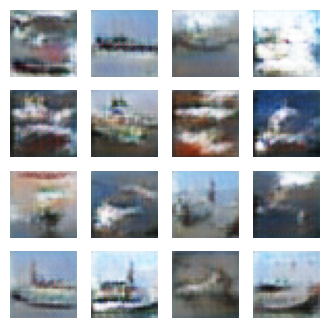

<Figure size 1600x1600 with 0 Axes>

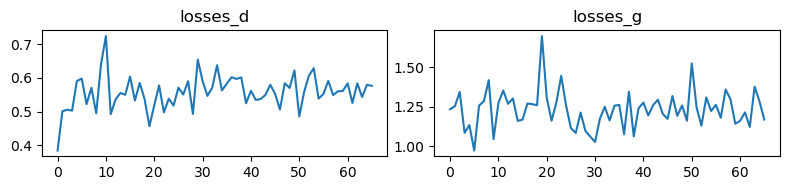

Epoch 66
Time for epoch:  22.70801591873169
Epoch 67
Time for epoch:  22.81491470336914
Epoch 68
Time for epoch:  22.773157119750977
Epoch 69
Time for epoch:  22.692917346954346
Epoch 70
Time for epoch:  22.8938992023468
loss_d=0.59344, loss_g=1.17066
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


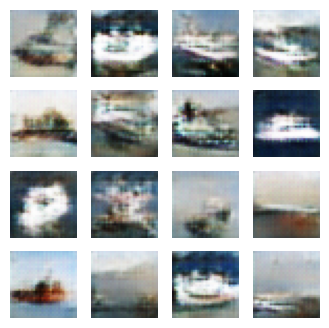

<Figure size 1600x1600 with 0 Axes>

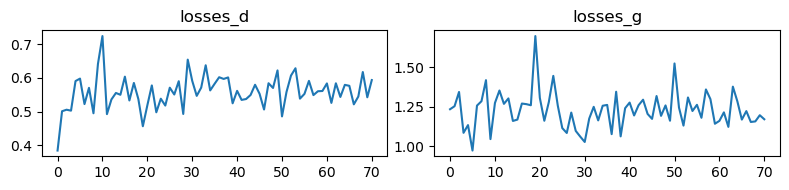

Epoch 71
Time for epoch:  22.811760187149048
Epoch 72
Time for epoch:  23.256327390670776
Epoch 73
Time for epoch:  22.711963176727295
Epoch 74
Time for epoch:  23.131516218185425
Epoch 75
Time for epoch:  22.800423860549927
loss_d=0.56756, loss_g=0.97365
2/2 [==============================] - 0s 3ms/step
	Plotting images and losses


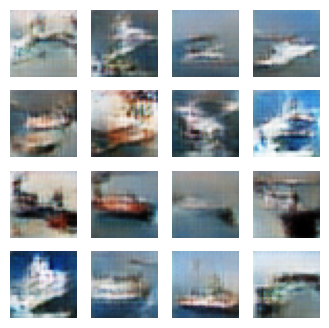

<Figure size 1600x1600 with 0 Axes>

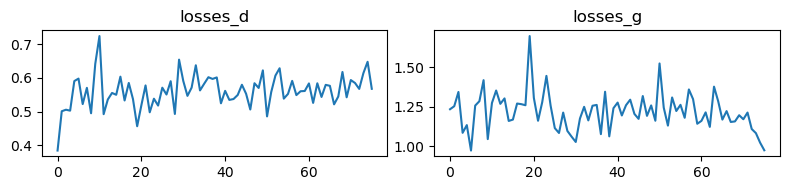

Epoch 76
Time for epoch:  22.697364807128906
Epoch 77
Time for epoch:  22.693930625915527
Epoch 78
Time for epoch:  24.073148488998413
Epoch 79
Time for epoch:  25.37268376350403
Epoch 80
Time for epoch:  23.25951051712036
loss_d=0.57978, loss_g=1.06855
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


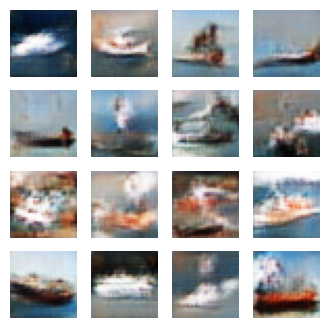

<Figure size 1600x1600 with 0 Axes>

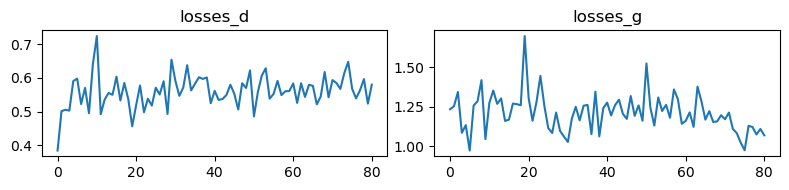

Epoch 81
Time for epoch:  23.66788625717163
Epoch 82
Time for epoch:  23.045069456100464
Epoch 83
Time for epoch:  24.19423484802246
Epoch 84
Time for epoch:  23.8938729763031
Epoch 85
Time for epoch:  22.995364904403687
loss_d=0.58191, loss_g=1.04048
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


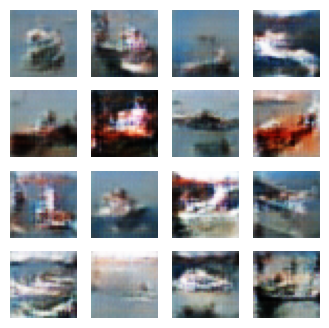

<Figure size 1600x1600 with 0 Axes>

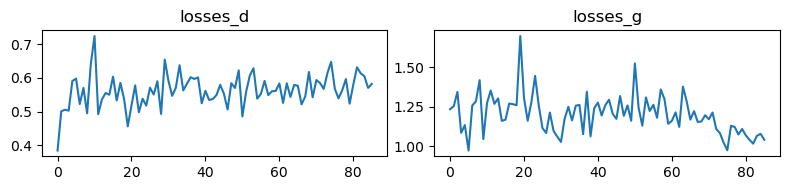

Epoch 86
Time for epoch:  22.761377096176147
Epoch 87
Time for epoch:  22.686323642730713
Epoch 88
Time for epoch:  22.837780952453613
Epoch 89
Time for epoch:  22.77268648147583
Epoch 90
Time for epoch:  22.839612007141113
loss_d=0.59252, loss_g=1.11322
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


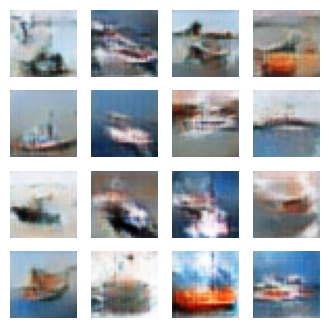

<Figure size 1600x1600 with 0 Axes>

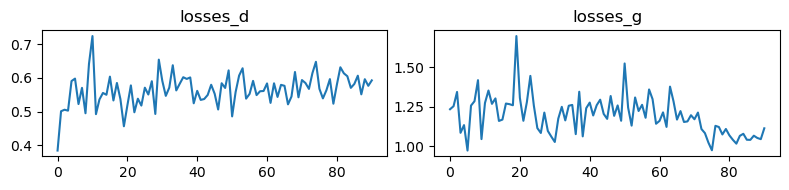

Epoch 91
Time for epoch:  22.700047492980957
Epoch 92
Time for epoch:  22.69216537475586
Epoch 93
Time for epoch:  22.777519702911377
Epoch 94
Time for epoch:  22.652859926223755
Epoch 95
Time for epoch:  24.62361717224121
loss_d=0.59057, loss_g=1.17653
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


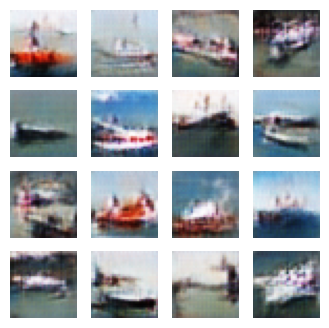

<Figure size 1600x1600 with 0 Axes>

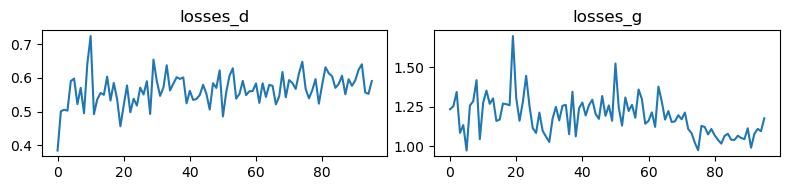

Epoch 96
Time for epoch:  23.46688675880432
Epoch 97
Time for epoch:  23.77879309654236
Epoch 98
Time for epoch:  23.22855019569397
Epoch 99
Time for epoch:  22.67037606239319
Epoch 100
Time for epoch:  23.688050985336304
loss_d=0.54706, loss_g=1.22073
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


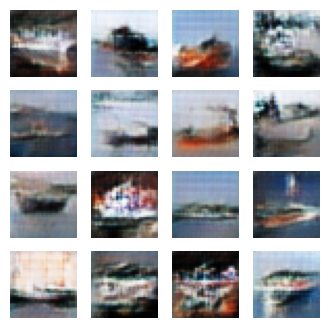

<Figure size 1600x1600 with 0 Axes>

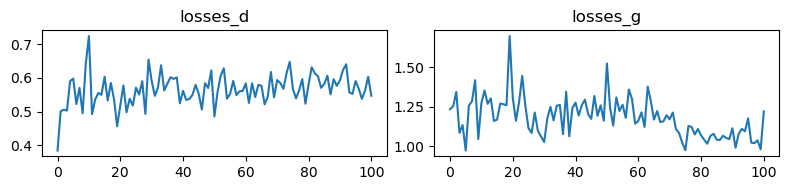

Epoch 101
Time for epoch:  24.38638997077942
Epoch 102
Time for epoch:  24.962844848632812
Epoch 103
Time for epoch:  23.236194610595703
Epoch 104
Time for epoch:  23.30092430114746
Epoch 105
Time for epoch:  23.012385845184326
loss_d=0.63119, loss_g=0.99760
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


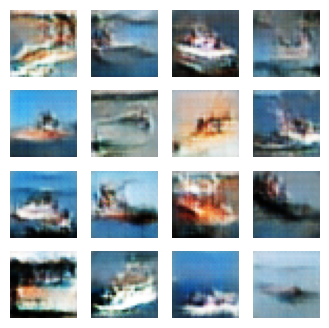

<Figure size 1600x1600 with 0 Axes>

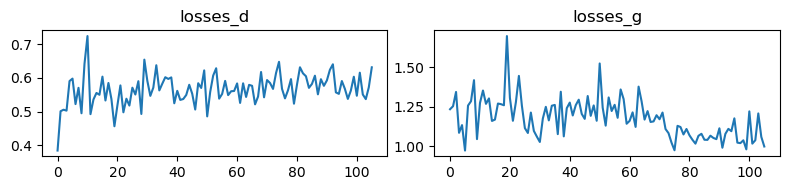

Epoch 106
Time for epoch:  23.64048671722412
Epoch 107
Time for epoch:  23.988397121429443
Epoch 108
Time for epoch:  23.636144876480103
Epoch 109
Time for epoch:  23.487045526504517
Epoch 110
Time for epoch:  24.04949951171875
loss_d=0.60390, loss_g=1.02683
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


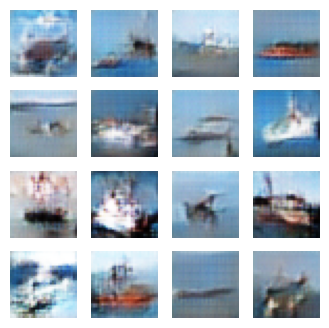

<Figure size 1600x1600 with 0 Axes>

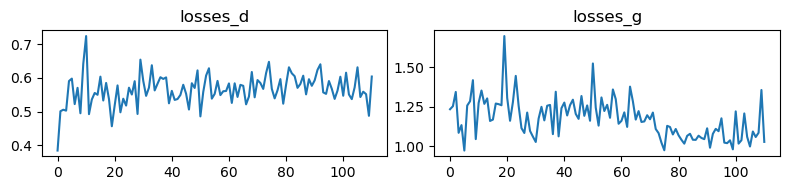

Epoch 111
Time for epoch:  22.864973545074463
Epoch 112
Time for epoch:  23.3363835811615
Epoch 113
Time for epoch:  22.817196130752563
Epoch 114
Time for epoch:  23.356956005096436
Epoch 115
Time for epoch:  23.400577783584595
loss_d=0.55753, loss_g=1.11364
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


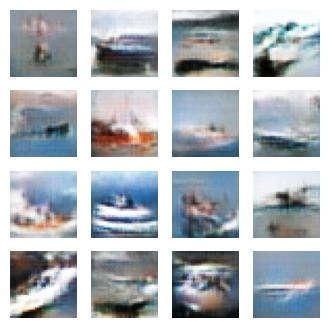

<Figure size 1600x1600 with 0 Axes>

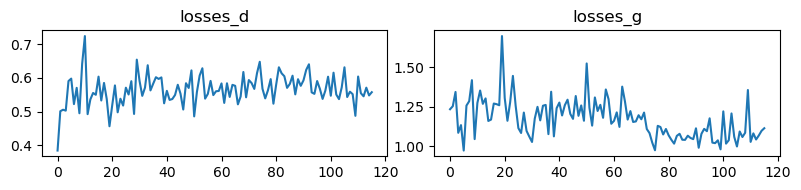

Epoch 116
Time for epoch:  22.57587480545044
Epoch 117
Time for epoch:  22.561366081237793
Epoch 118
Time for epoch:  22.63149666786194
Epoch 119
Time for epoch:  22.548826694488525
Epoch 120
Time for epoch:  22.843514680862427
loss_d=0.55426, loss_g=1.13003
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


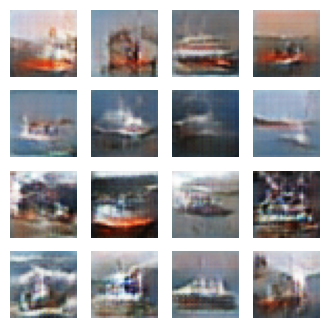

<Figure size 1600x1600 with 0 Axes>

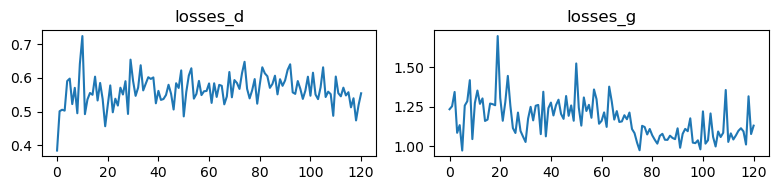

Epoch 121
Time for epoch:  22.927713632583618
Epoch 122
Time for epoch:  23.137935400009155
Epoch 123
Time for epoch:  23.32884168624878
Epoch 124
Time for epoch:  23.075124263763428
Epoch 125
Time for epoch:  23.04106831550598
loss_d=0.53995, loss_g=1.20135
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


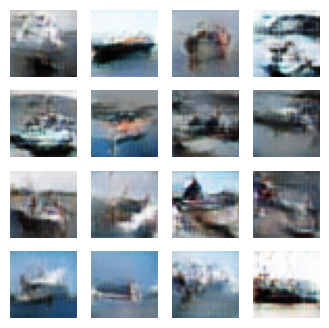

<Figure size 1600x1600 with 0 Axes>

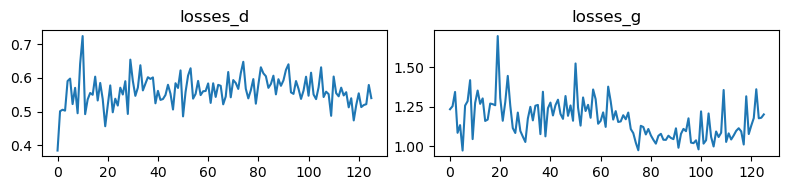

Epoch 126
Time for epoch:  23.852813959121704
Epoch 127
Time for epoch:  22.94864773750305
Epoch 128
Time for epoch:  23.077381372451782
Epoch 129
Time for epoch:  23.317628622055054
Epoch 130
Time for epoch:  23.057568550109863
loss_d=0.52264, loss_g=1.23771
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


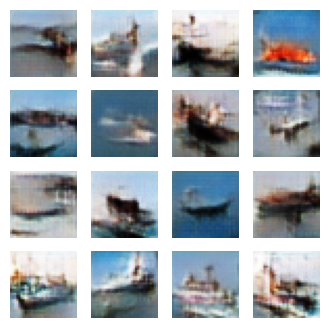

<Figure size 1600x1600 with 0 Axes>

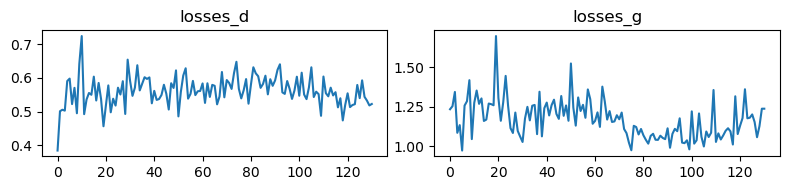

Epoch 131
Time for epoch:  22.948569536209106
Epoch 132
Time for epoch:  22.970621824264526
Epoch 133
Time for epoch:  23.380714893341064
Epoch 134
Time for epoch:  23.518014669418335
Epoch 135
Time for epoch:  24.662049055099487
loss_d=0.54687, loss_g=1.18956
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


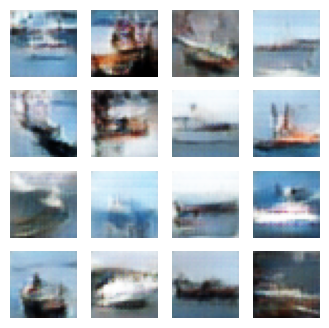

<Figure size 1600x1600 with 0 Axes>

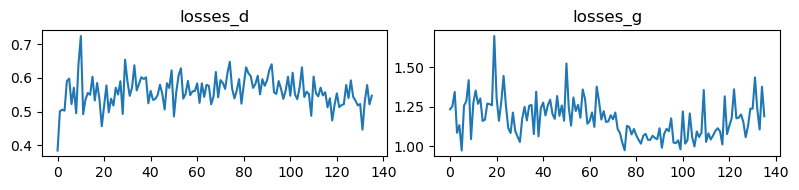

Epoch 136
Time for epoch:  23.829031944274902
Epoch 137
Time for epoch:  23.435096502304077
Epoch 138
Time for epoch:  24.926833152770996
Epoch 139
Time for epoch:  25.066284894943237
Epoch 140
Time for epoch:  25.347399950027466
loss_d=0.51321, loss_g=1.28410
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


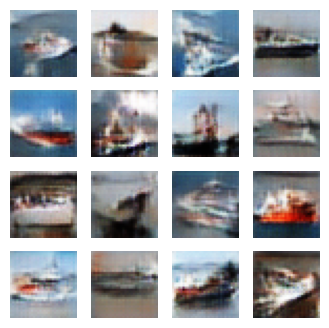

<Figure size 1600x1600 with 0 Axes>

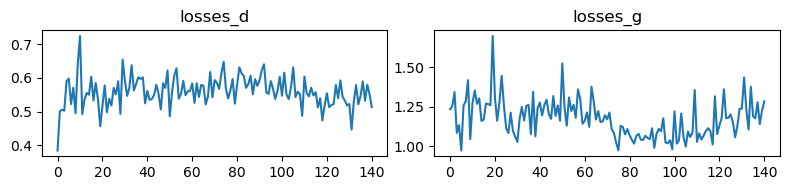

Epoch 141
Time for epoch:  24.864245414733887
Epoch 142
Time for epoch:  25.27993655204773
Epoch 143
Time for epoch:  24.898521423339844
Epoch 144
Time for epoch:  25.033031463623047
Epoch 145
Time for epoch:  24.218565464019775
loss_d=0.50775, loss_g=1.34512
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


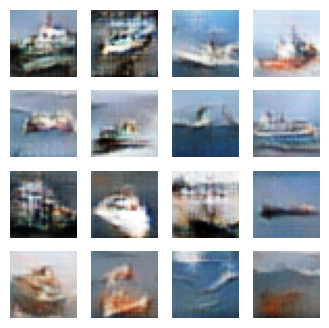

<Figure size 1600x1600 with 0 Axes>

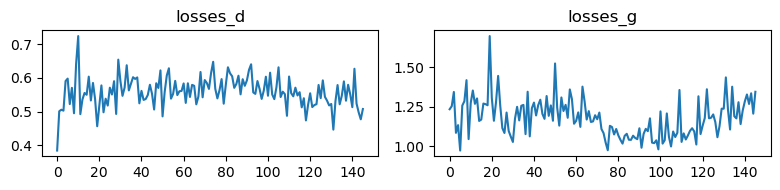

Epoch 146
Time for epoch:  26.484028816223145
Epoch 147
Time for epoch:  25.452950716018677
Epoch 148
Time for epoch:  23.685774564743042
Epoch 149
Time for epoch:  23.63118886947632


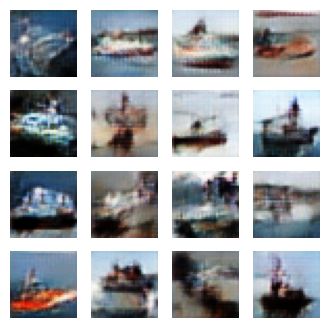

In [5]:
#Training Function
def train(z_dim=100, epochs=150,
          batch_size=16, epoch_per_checkpoint=5, n_checkpoint_images=36):

    #Load the CIFAR10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #Concatenate X_train and X_test for more data
    X_train = np.concatenate((X_train,X_test))
    y_train = np.concatenate((y_train,y_test))
    #Only grab ships
    index = np.where(y_train.reshape(-1) == 8)
    X_train = X_train[index]
    y_train = y_train[index]
    #Convert data to floats, Scale data to -1, 1
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = X_train/127.5 - 1.0
    
    
    #Get image shapes and values for reference
    image_shape = X_train[0].shape
    print("image shape {}, min val {}, max val {}".format(image_shape, X_train[0].min(), X_train[0].max()))
    #Plot real images for reference
    plot_images(X_train[:n_checkpoint_images], "real_images.png")


    #Get labels for computing the losses
    labels_real = np.ones(shape=(batch_size, 1)) 
    labels_fake = np.zeros(shape=(batch_size, 1))
    #Smooth labels to prevent mode collapse
    labels_real = smooth_positive_labels(labels_real)
    labels_fake = smooth_negative_labels(labels_fake)

    losses_d, losses_g = [], []

    
    # training loop
    for e in range(epochs):
        start = time.time()
        print("Epoch {}".format(e))
        for i in range(len(X_train) // batch_size):

            # update Discriminator weights
            D.trainable = True

            # Get real samples, train discriminator on them
            real_images = X_train[i*batch_size: (i+1)*batch_size]
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 real_images[j] = noisy(real_images[j])
            loss_d_real = D.train_on_batch(x=real_images, y=labels_real)[0]

            # Make fake samples, train discriminator on them
            z = generate_latent_points(z_dim, batch_size)
            fake_images = G.predict_on_batch(z)
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 fake_images[j] = noisy(fake_images[j])
            loss_d_fake = D.train_on_batch(x=fake_images, y=labels_fake)[0]

            # Compute Discriminator's loss
            loss_d = 0.5 * (loss_d_real + loss_d_fake)

#             # Train the generator while the discriminator is static
#             D.trainable = False
#             loss_g1 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
#             # Update Generator again (train it twice as much as the Discriminator)
#             loss_g2 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
            
#             # Compute Generator's loss
#             loss_g = 0.5 * (loss_g1 + loss_g2)
            # Train the generator while the discriminator is static
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=labels_real)[0]


        #Keep track of losses for plotting
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        
        end = time.time()
        print("Time for epoch:  " + str(end-start))

        
        #Plot losses and generated images every X epochs
        if (e % epoch_per_checkpoint) == 0:
            print("loss_d={:.5f}, loss_g={:.5f}".format(loss_d, loss_g))
            
            # fix a z vector for training evaluation
            z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
            
            fake_images = G.predict(z_fixed)
            print("\tPlotting images and losses")
            plot_images(fake_images, "fake_images_ships_e{}.png".format(e))
            plot_losses(losses_d, losses_g, "losses.png")
            
            #Show Images
            fake_images = (fake_images + 1) * 127.5
            fake_images = np.rint(fake_images)
            fake_images = fake_images.astype(int)

            fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)
            cnt=0
            for k in range(4):
                for l in range(4):
                    axs[k, l].imshow(fake_images[cnt,:,:])
                    axs[k, l].axis('off')
                    cnt+=1

            #Save Model every 10 epochs
#             if (e % 10) == 0 and e != 0:
#                 print('Saving Models')
#                 D.save('./DiscriminatorModel')
#                 D_of_G.save('./CombinedModel')
            
            
train()

4/4 [==============================] - 0s 9ms/step


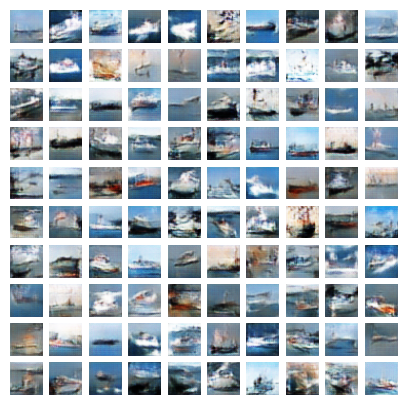

In [6]:
# #Print example images 
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(5,5),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1

4/4 [==============================] - 0s 9ms/step


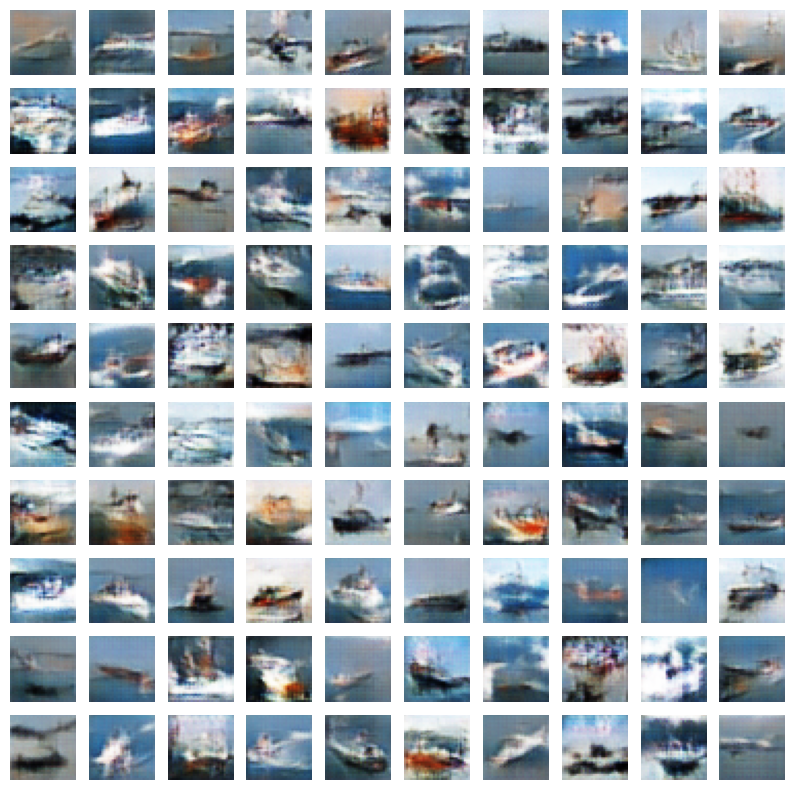

In [8]:
# #Print example images 
#Default Sets, 250 epochs
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(10,10),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1